# Analizando datos del cluster de Univalle

En este *notebook* se mostrarán las instrucciones que permitirán analizar los datos del cluster de Univalle.

El código abajo lee datos el archivo `history.csv`. 

In [2]:
import pandas as pd

CSVFILENAME = 'history.csv.gz'

df = pd.read_csv(CSVFILENAME,compression="gzip")

Se usa como índice del análisis el campo `JobCurrentStartDate`.

In [3]:
INDEXFIELD = 'JobCurrentStartDate'

df[INDEXFIELD] = pd.to_datetime(df[INDEXFIELD], unit='s')
df = df.set_index(INDEXFIELD)

A continuación se definen unas funciones auxiliares que permitirán visualizar los datos.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import math

def analizarRangoAnos(ano1,ano2):
    values = [] # valores reales
    vallog = [] # valores logaritmicos
    xlabel = []
    contador = 1
    for i in range(ano1, ano2 + 1):
        for j in range(1, 13):
            fecha = '%d-%d'%(i,j)
            valT = df.loc[fecha].shape[0]
            values.append(valT)
            if valT <= 0:
                valT = 1
            vallog.append(math.log2(valT))
            #xlabel.append(fecha)
            xlabel.append(contador)
            contador = contador + 1

    return (xlabel, vallog, values)

def analizarPorAno(ano):
    return analizarRangoAnos(ano, ano)

def showPlot(xlab, val):
    fit = plt.figure()
    plt.plot(xlab,val)
    plt.grid()
    plt.show()

Si usted desear revisar el de un año se ejecuta el siguiente código

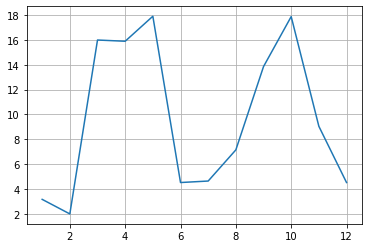

[9, 4, 64770, 60445, 243662, 23, 25, 142, 14730, 238992, 528, 23]

In [7]:
(xlab, vallog, realvalues) = analizarPorAno(2018)
showPlot(xlab, vallog)
realvalues

Si usted desea revisar el rango de años del 2015 al 2019 se debe ejecutar el siguiente código.

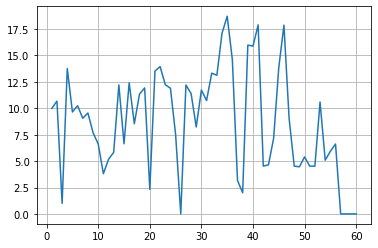

[1018,
 1635,
 2,
 13877,
 802,
 1212,
 532,
 751,
 206,
 98,
 14,
 36,
 57,
 4742,
 100,
 5441,
 372,
 2588,
 3893,
 5,
 11747,
 15772,
 4801,
 3803,
 184,
 1,
 4725,
 2701,
 300,
 3392,
 1699,
 10231,
 8925,
 141354,
 429185,
 24867,
 9,
 4,
 64770,
 60445,
 243662,
 23,
 25,
 142,
 14730,
 238992,
 528,
 23,
 22,
 42,
 23,
 23,
 1547,
 34,
 61,
 98,
 0,
 0,
 0,
 0]

In [9]:
(xlab, vallog, realvalues) = analizarRangoAnos(2015, 2019)
showPlot(xlab, vallog)
realvalues